#### Model Development
- Build and compare classifiers Random Forest, Gradient Boosting
- Use **MLflow** to track model metrics and experiment details
- Evaluate performance using accuracy, precision, recall, F1-score (for classification) or RMSE/MAE (for regression)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

In [2]:
# Import dataset

data = 'dataset/column_2C_weka.csv'
dataset = pd.read_csv(data)

In [3]:
# Convert the 'class' column to a binary encoding: 1 for 'Abnormal', 0 for 'Normal'
def encode_class(uncoded_class):
    if uncoded_class == 'Normal':
        return 0
    elif uncoded_class == 'Abnormal' or uncoded_class == 'Hernia':
        return 1
    elif uncoded_class == 'Spondylolisthesis':
        return 2
    else:
        return f"Unknown class '{uncoded_class}'"

dataset['class'] = dataset['class'].apply(encode_class)
# dataset.drop(columns=['class'], inplace=True)  # Drop the original class column



In [4]:
# Separate features from dependent variable

X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]


In [5]:
# feature = 'pelvic_incidence'
for feature in X.columns:
    min_value = dataset[feature].min()
    max_value = dataset[feature].max()
    print(feature, "Range:", min_value, "to", max_value)


pelvic_incidence Range: 26.14792141 to 129.8340406
pelvic_tilt Range: -6.554948347 to 49.4318636
lumbar_lordosis_angle Range: 14.0 to 125.7423855
sacral_slope Range: 13.3669307 to 121.4295656
pelvic_radius Range: 70.08257486 to 163.0710405
degree_spondylolisthesis Range: -11.05817866 to 418.5430821


In [6]:
# Compare the mean of all features by class to see the difference in value between the normal and abnormal class

dataset.groupby('class').mean()


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
class,,,,,,
0,51.685244,12.821414,43.542605,38.86383,123.890834,2.186572
1,64.692562,19.791111,55.925370,44.90145,115.077713,37.777705


In [7]:
print(type(X))
print(type(y))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [8]:
# Compare the correlation between the Class and the features

numeric_dataset = dataset.select_dtypes(include=[np.number])
numeric_dataset_columns = X.select_dtypes(include=[np.number]).columns.tolist()
dataset.corr()['class'].sort_values(ascending=False)
# numeric_dataset

class                       1.000000
degree_spondylolisthesis    0.443687
pelvic_incidence            0.353336
pelvic_tilt                 0.326063
lumbar_lordosis_angle       0.312484
sacral_slope                0.210602
pelvic_radius              -0.309857
Name: class, dtype: float64

In [9]:
n_cols = 2
n_rows = (len(X.columns) + n_cols - 1) // n_cols

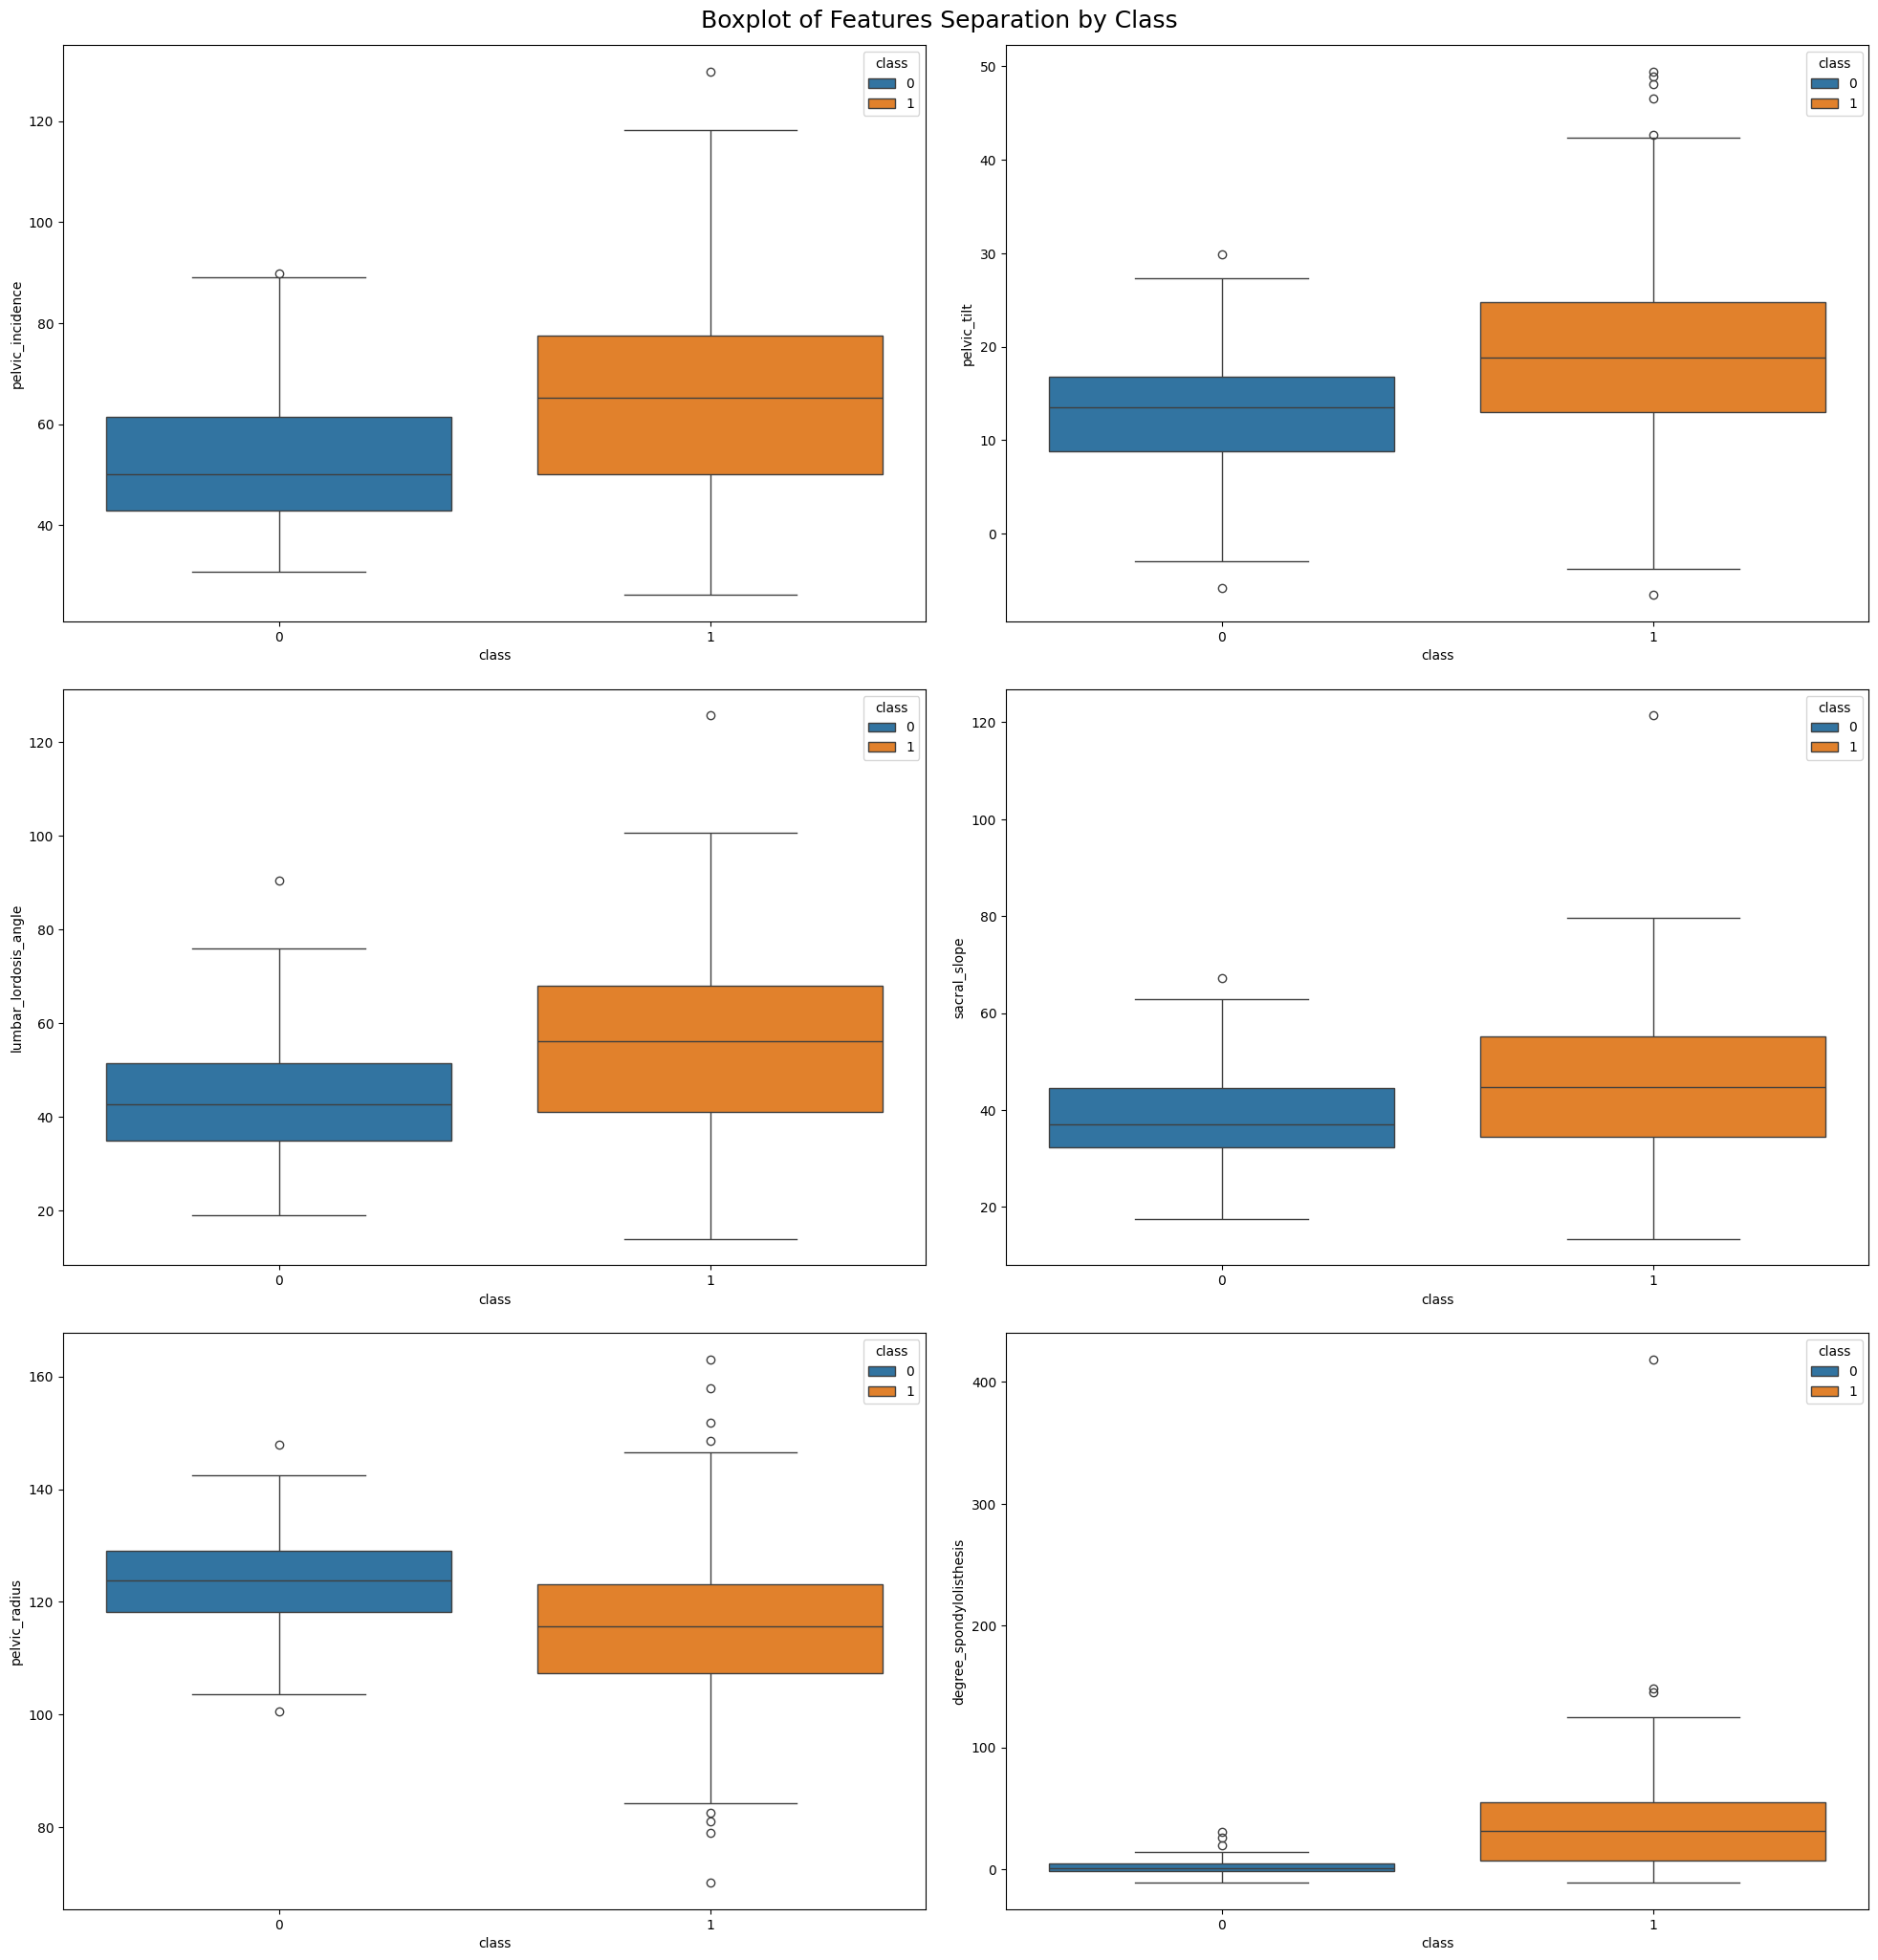

In [10]:
# Box Plot
plt.figure(figsize=(20, n_rows * 7))
plt.suptitle('Boxplot of Features Separation by Class', fontsize=18)
for index, column in enumerate(X, start=1):
    plt.subplot(n_rows, n_cols, index)
    sns.boxplot(
        data = X,
        x = y,
        y = column,
        hue = y
    )
    plt.xlabel(y.name)
    plt.ylabel(column)

plt.tight_layout(pad=2)
# wandb.log({'Feature-Target-Correlation':wandb.Image(plt)}) # Log the box plots to WandB
plt.savefig("images/model-dev/boxplot")  # Save the box plots as an image
plt.show()  # Show the box plots
plt.close()  # Close the plot


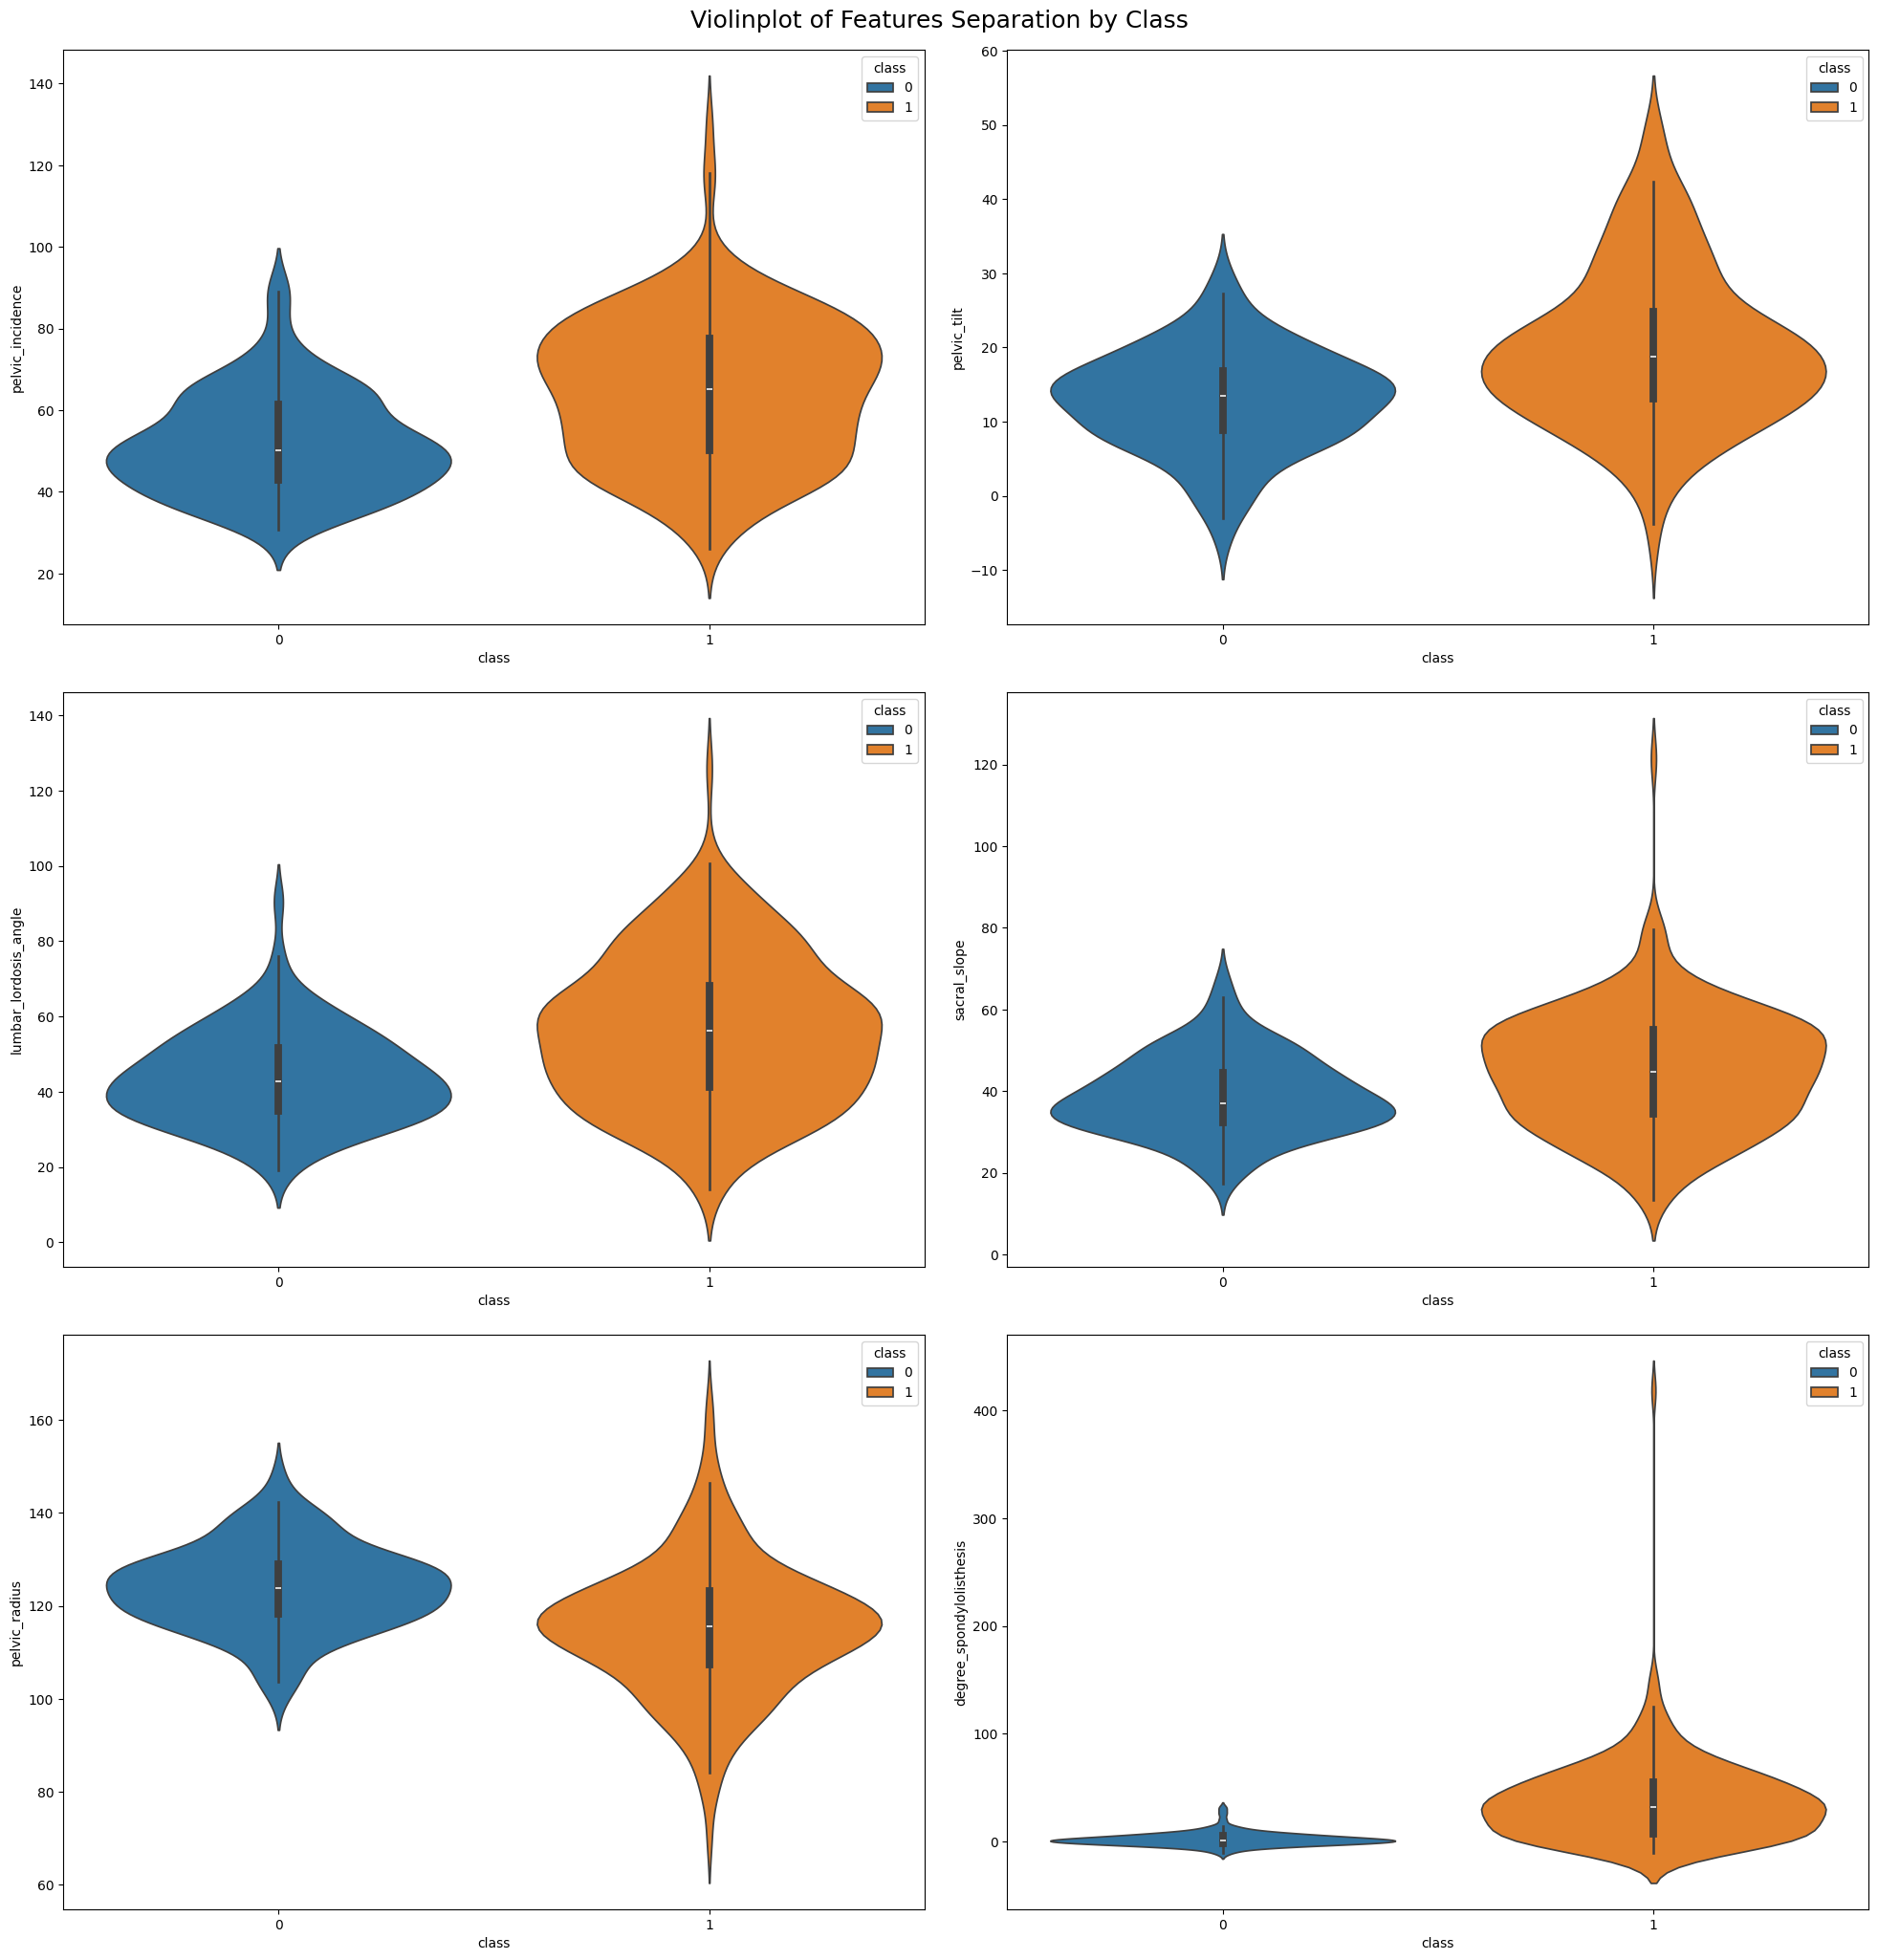

In [11]:
# violin Plot
plt.figure(figsize=(20, n_rows * 7))
plt.suptitle('Violinplot of Features Separation by Class', fontsize=18)
for index, column in enumerate(X, start=1):
    plt.subplot(n_rows, n_cols, index)
    sns.violinplot(
        data = X,
        x = y,
        y = column,
        hue = y
    )
    plt.xlabel(y.name)
    plt.ylabel(column)
plt.tight_layout(pad=2)
# wandb.log({'violinplot':wandb.Image(plt)}) # Log the box plots to WandB
plt.savefig("images/model-dev/violinplot")  # Save the box plots as an image
plt.show()  # Show the box plots
plt.close()  # Close the plot


In [12]:

for feature in numeric_dataset_columns:
    tstatistic, pvalue = ttest_ind(numeric_dataset[numeric_dataset['class']==0][feature], numeric_dataset[numeric_dataset['class']==1][feature])
    print(f'{feature}:')
    print("t-statistic:", tstatistic)
    print("p-value:", pvalue)
    print('')




pelvic_incidence:
t-statistic: -6.6285856350132955
p-value: 1.516337137438054e-10

pelvic_tilt:
t-statistic: -6.053206646787071
p-value: 4.122674154069914e-09

lumbar_lordosis_angle:
t-statistic: -5.773180434184712
p-value: 1.898448510588465e-08

sacral_slope:
t-statistic: -3.7808470712114293
p-value: 0.00018769555657203096

pelvic_radius:
t-statistic: 5.719452250763981
p-value: 2.5290220394267037e-08

degree_spondylolisthesis:
t-statistic: -8.688731198808457
p-value: 2.2012863107202555e-16



In [13]:
y.value_counts().reset_index()

,class,count
0,1,210
1,0,100


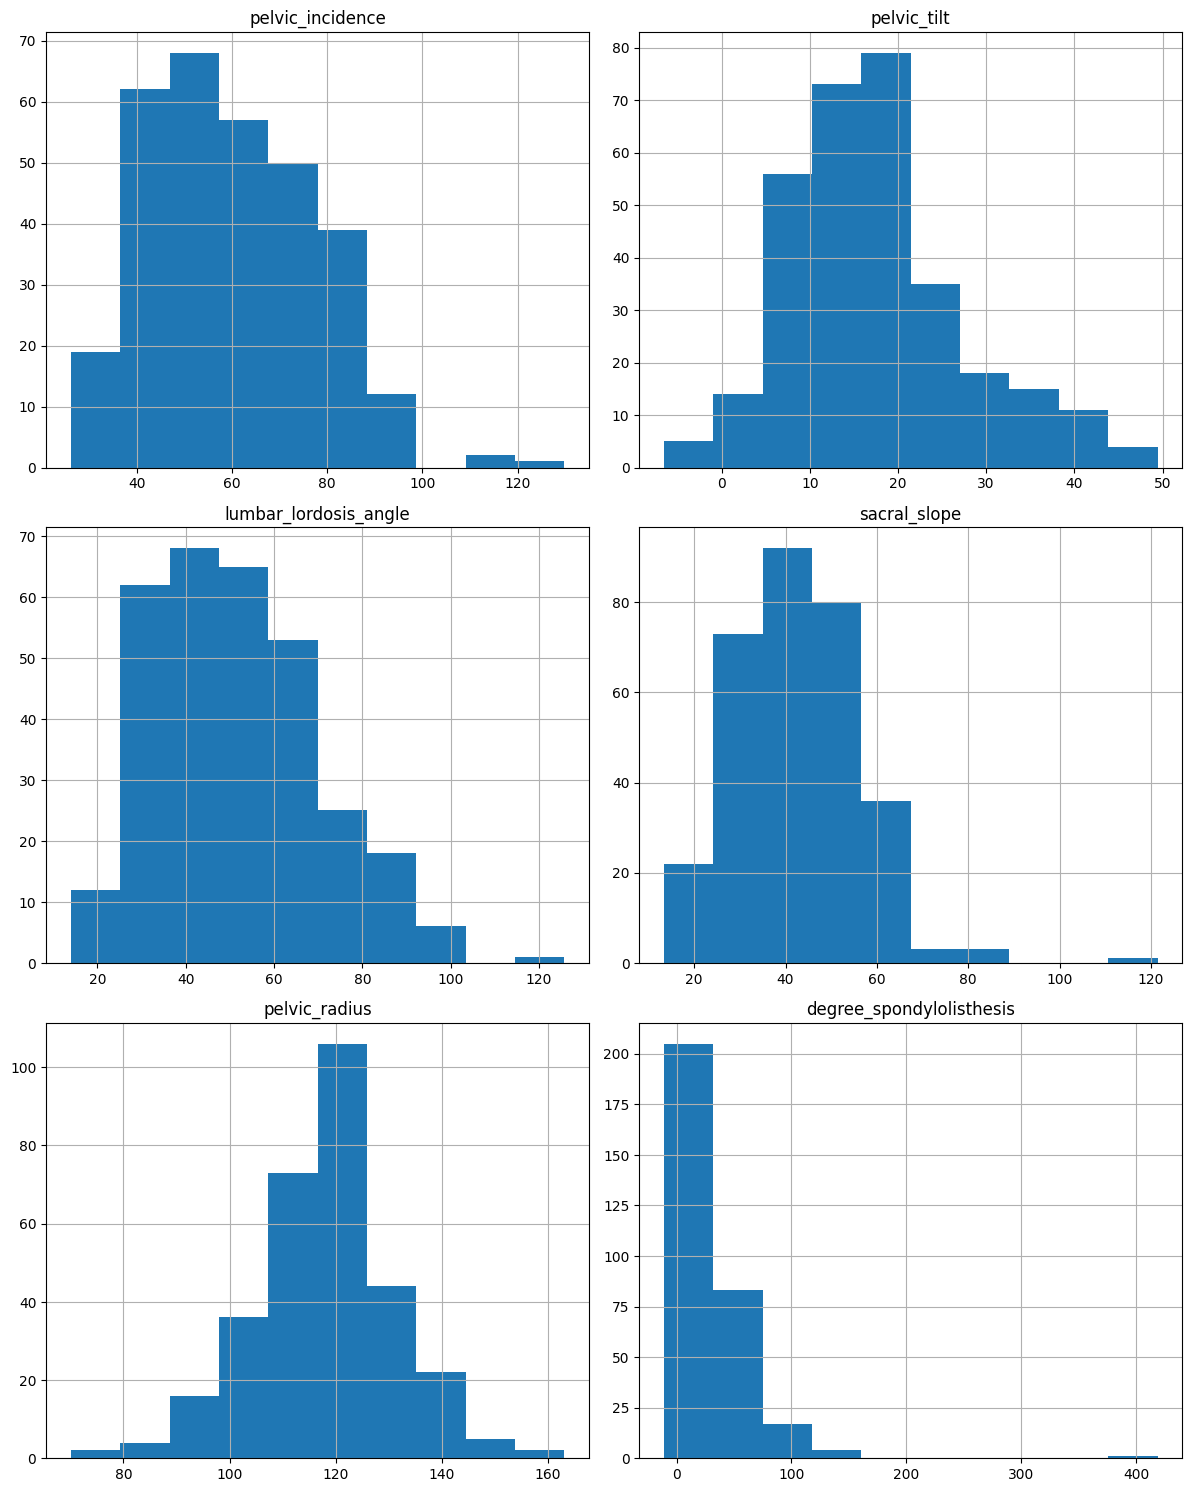

In [14]:
X.hist(figsize=(12, 15))
plt.tight_layout(pad=1)
# wandb.log({'violinplot':wandb.Image(plt)}) # Log the box plots to WandB
plt.savefig("images/model-dev/histogram_skewness")  # Save the box plots as an image

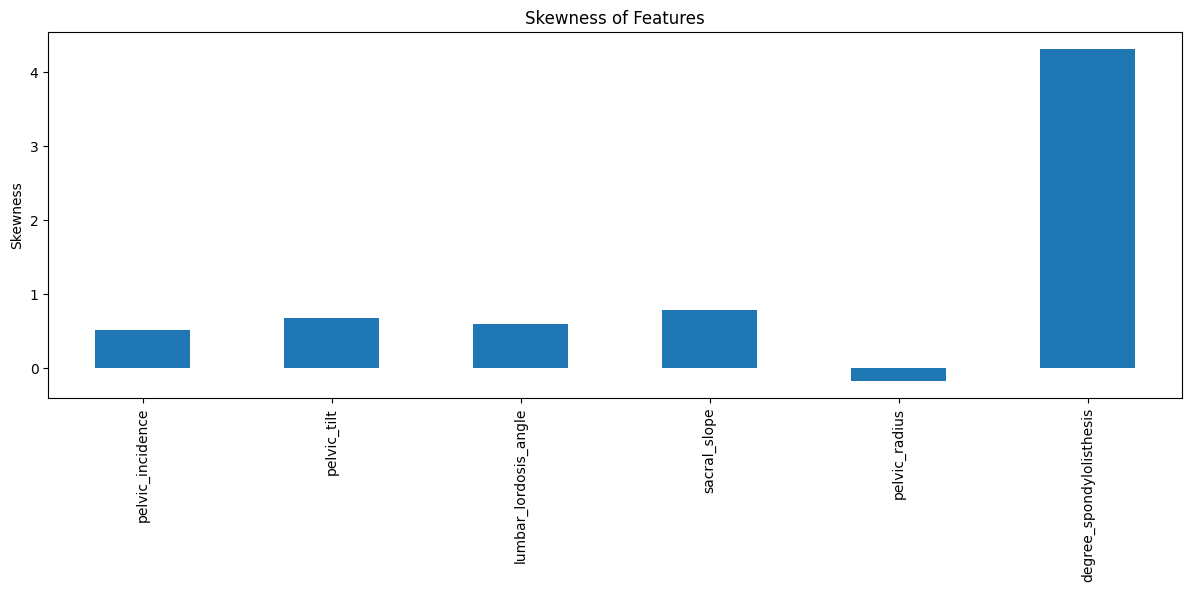

In [15]:
skewness = X.skew()
plt.figure(figsize=(12, 6))
skewness.plot(kind='bar')
plt.title('Skewness of Features')
plt.ylabel('Skewness')
plt.tight_layout(pad=1)
# wandb.log({'skewness_bar':wandb.Image(plt)}) # Log the skewness bar plot to WandB
plt.savefig("images/model-dev/skewness_degree")  # Save the plot as an image
plt.show()
plt.close()

In [16]:
skewed_features = ['degree_spondylolisthesis']

X_sds = dataset.copy()

for feature in skewed_features:
    X_sds[feature + '_log'] = np.log1p(X[feature])
    X_sds.drop(columns=[feature], inplace=True)
    # print(dataset)
    # skewness = X.skew()
# plt.figure(figsize=(12, 6))
# skewness.plot(kind='bar')
# plt.title('Skewness of Features')
# plt.ylabel('Skewness')
# plt.tight_layout(pad=1)
# X.hist(figsize=(12, 15))
# plt.tight_layout(pad=1)
# X_sds.dropna(inplace=True)  # Drop rows with NaN values after log transformation
# pd.set_option('display.max_rows', None)  # Show all columns in the DataFrame
X_sds['degree_spondylolisthesis_log'] = X_sds.groupby('class')['degree_spondylolisthesis_log'].transform(lambda x: x.fillna(x.mean()))  
X_sds.drop(columns=['class'], inplace=True)  # Drop the original feature after log transformation
X_sds.drop(columns=['pelvic_incidence'], inplace=True)  # Drop the original feature after log transformation
X_sds.drop(columns=['lumbar_lordosis_angle'], inplace=True)  # Drop the original feature after log transformation

# X.drop(columns=['lumbar_lordosis_angle'], inplace=True)  # Drop the original feature after log transformation
# X.drop(columns=['pelvic_incidence'], inplace=True)  # Drop the original feature after log transformation
X_sds

c:\Users\Another1\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,pelvic_tilt,sacral_slope,pelvic_radius,degree_spondylolisthesis_log
0,22.552586,40.475232,98.672917,-0.293566
1,10.060991,28.995960,114.405425,1.716364
2,22.218482,46.613539,105.985135,3.260511
3,24.652878,44.644130,101.868495,2.502380
4,9.652075,40.060784,108.168725,2.188128
...,...,...,...,...
305,13.616688,34.286877,117.449062,1.168426
306,20.721496,33.215251,114.365845,-0.546471
307,22.694968,38.751628,125.670725,1.168426
308,8.693157,36.559635,118.545842,0.194538


In [17]:
# Create a pipeline: scaling + model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Use cross-validation (StratifiedKFold for classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using cross_val_score
scores = cross_val_score(pipeline, X_sds, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracy scores:", scores)
print("Average CV accuracy:", scores.mean())

cm = confusion_matrix(y, pipeline.fit(X_sds, y).predict(X_sds))
print("Confusion Matrix:\n", cm)

accuracy = accuracy_score(y, pipeline.predict(X_sds))
print("Accuracy:", accuracy)

classification_rep = classification_report(y, pipeline.predict(X_sds))
print("Classification Report:\n", classification_rep)

Cross-validation accuracy scores: [0.85483871 0.83870968 0.87096774 0.91935484 0.87096774]
Average CV accuracy: 0.8709677419354838
Confusion Matrix:
 [[ 78  22]
 [ 18 192]]
Accuracy: 0.8709677419354839
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.80       100
           1       0.90      0.91      0.91       210

    accuracy                           0.87       310
   macro avg       0.85      0.85      0.85       310
weighted avg       0.87      0.87      0.87       310



In [18]:
# Create a pipeline: scaling + model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier())
    # ('model', LogisticRegression())
    # ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Use cross-validation (StratifiedKFold for classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using cross_val_score
scores = cross_val_score(pipeline, X_sds, y, cv=cv, scoring='accuracy')

# X
print("Cross-validation accuracy scores:", scores)
print("Average CV accuracy:", scores.mean())

cm = confusion_matrix(y, pipeline.fit(X_sds, y).predict(X_sds))
print("Confusion Matrix:\n", cm)

accuracy = accuracy_score(y, pipeline.predict(X_sds))
print("Accuracy:", accuracy)

classification_rep = classification_report(y, pipeline.predict(X_sds))
print("Classification Report:\n", classification_rep)

Cross-validation accuracy scores: [0.82258065 0.90322581 0.88709677 0.91935484 0.87096774]
Average CV accuracy: 0.8806451612903226
Confusion Matrix:
 [[100   0]
 [  0 210]]
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       210

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310



In [19]:
# Create a pipeline: scaling + model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Use cross-validation (StratifiedKFold for classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using cross_val_score
scores = cross_val_score(pipeline, X_sds, y, cv=cv, scoring='accuracy')

# X
print("Cross-validation accuracy scores:", scores)
print("Average CV accuracy:", scores.mean())

cm = confusion_matrix(y, pipeline.fit(X_sds, y).predict(X_sds))
print("Confusion Matrix:\n", cm)

accuracy = accuracy_score(y, pipeline.predict(X_sds))
print("Accuracy:", accuracy)

classification_rep = classification_report(y, pipeline.predict(X_sds))
print("Classification Report:\n", classification_rep)

Cross-validation accuracy scores: [0.79032258 0.90322581 0.87096774 0.88709677 0.91935484]
Average CV accuracy: 0.8741935483870968
Confusion Matrix:
 [[100   0]
 [  0 210]]
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       210

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310



In [20]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Scale your features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sds)

# Add intercept manually
X_scaled = sm.add_constant(X_scaled)

# Fit logistic regression model
model = sm.Logit(y, X_scaled)
result = model.fit(maxiter=1000)
# result = model.fit_regularized(method='l1')  # or 'l2'


# Print model summary
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.298554
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  310
Model:                          Logit   Df Residuals:                      305
Method:                           MLE   Df Model:                            4
Date:                Sun, 27 Jul 2025   Pseudo R-squ.:                  0.5252
Time:                        10:19:16   Log-Likelihood:                -92.552
converged:                       True   LL-Null:                       -194.93
Covariance Type:            nonrobust   LLR p-value:                 3.574e-43
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5340      0.232      6.613      0.000       1.079       1.989
x1             0.7411      0.

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X_scaled includes constant at col 0
X_no_const = X_scaled[:, 1:]  # remove constant column

vif = [variance_inflation_factor(X_no_const, i) for i in range(X_no_const.shape[1])]
print("VIF for each feature:", vif)


VIF for each feature: [1.1880656666152745, 1.3936234104744685, 1.1387685521059157, 1.4796921241428844]


In [22]:
df = pd.DataFrame(X_no_const, columns=['x1', 'x2', 'x3', 'x4'])
print(df.corr())

          x1        x2        x3        x4
x1  1.000000  0.062345  0.032668  0.374087
x2  0.062345  1.000000 -0.342128  0.450038
x3  0.032668 -0.342128  1.000000 -0.170891
x4  0.374087  0.450038 -0.170891  1.000000
